In [2]:
import networkx as nx
import numpy as np
import torch
from model import CaT
import inference
import pandas as pd
import matplotlib.pyplot as plt
from datasets import get_full_ordering, reorder_dag

shuffling = 0
seed = 1
standardize = 0
sample_size = 100000
batch_size = 100
max_iters = 100000
eval_interval = 100
eval_iters = 100
validation_fraction = 0.3
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cuda'
dropout_rate = 0.0
learning_rate = 5e-3
ff_n_embed = 6
num_heads = 2
n_layers = 2
head_size = 6


We create data from a 'true' DAG (which is DAGnx3 below) but also provide two other DAGs which are incorrect in different ways. DAGnx1 is fully exogenous, and DAGnx2 has one missing edge and another directed edge reversed.

We imagine we are interested in the 'total' effect of X -> Y.  As these simulations are linear, this effect can be calculated easily by hand.

In the case where X1 -> Y and X1 -> X2 -> Y, the total effect is the sum of the effect from both paths. e.g. if X1 -> Y has a coefficient of  0.8,  X1 -> X2 of 0.8, and X2 -> Y of 0.7, then the total effect is 0.8 + (0.8 x 0.7) = 1.36

In [4]:
def generate_data(N, d=1):
    DAGnx1 = nx.DiGraph()
    DAGnx2 = nx.DiGraph()
    DAGnx3 = nx.DiGraph()  # correct graph
    
    Ux1 = np.random.randn(N,d)
    X1 =  Ux1

    Ux2 = np.random.randn(N,d)
    X2 =  0.8 * X1 + Ux2
    
    X20 = Ux2
    X21 = 0.8 + Ux2

    Uy = np.random.randn(N,d)
    Y =  0.8 * X1 + 0.4 * X2 + Uy
    
    Ux3 = np.random.randn(N,d)
    X3 = 0.7 * Y + 0.6 * X1 + Ux3

    Y0 = 0.4 * X20 + Uy 
    Y1 = 0.8 + 0.4 * X21 + Uy

    all_data_dict = {'X1': X1, 'X2': X2, 'X3': X3, 'Y': Y}

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X1': 'cont', 'X2': 'cont', 'X3': 'cont', 'Y': 'cont'}

    DAGnx1.add_edges_from([('X1', 'Y'), ('X2', 'Y'), ('X3', 'Y')])
    DAGnx1 = reorder_dag(dag=DAGnx1)  # topologically sorted dag
    var_names1 = list(DAGnx1.nodes())  # topologically ordered list of variables
    all_data1 = np.stack([all_data_dict[key] for key in var_names1], axis=1)
    causal_ordering1 = get_full_ordering(DAGnx1)
    ex_dag_stuff = (all_data1, DAGnx1, var_names1, causal_ordering1, var_types)
    
    DAGnx2.add_edges_from([('X1', 'Y'), ('X1', 'X2'), ('X2', 'Y'), ('X3', 'Y')])
    DAGnx2 = reorder_dag(dag=DAGnx2)  # topologically sorted dag
    var_names2 = list(DAGnx2.nodes())  # topologically ordered list of variables
    all_data2 = np.stack([all_data_dict[key] for key in var_names2], axis=1)
    causal_ordering2 = get_full_ordering(DAGnx2)
    mediated_dag_stuff = (all_data2, DAGnx2, var_names2, causal_ordering2, var_types)
    
    DAGnx3.add_edges_from([('X1', 'Y'), ('X1', 'X2'), ('X1', 'X3'), ('X2', 'Y'), ('Y', 'X3')])
    DAGnx3 = reorder_dag(dag=DAGnx3)  # topologically sorted dag
    var_names3 = list(DAGnx3.nodes())  # topologically ordered list of variables
    all_data3 = np.stack([all_data_dict[key] for key in var_names3], axis=1)
    causal_ordering3 = get_full_ordering(DAGnx3)
    correct_dag_stuff =  (all_data3, DAGnx3, var_names3, causal_ordering3, var_types)

    return ex_dag_stuff, mediated_dag_stuff, correct_dag_stuff, Y0, Y1

d=1
_, _, _, Y0, Y1 = generate_data(N=1000000, d=d)
ATE = (Y1 - Y0).mean(0)  
ex_dag_stuff, mediated_dag_stuff, correct_dag_stuff, Y0, Y1 = generate_data(N=sample_size, d=d)

all_data1, DAGnx1, var_names1, causal_ordering1, var_types1 = ex_dag_stuff
all_data2, DAGnx2, var_names2, causal_ordering2, var_types2 = mediated_dag_stuff
all_data3, DAGnx3, var_names3, causal_ordering3, var_types3 = correct_dag_stuff

print(var_names1, 'ATE of X1 on Y:', ATE)
print(all_data1.shape)

['X1', 'X2', 'X3', 'Y'] ATE of X1 on Y: [1.12]
(100000, 4, 1)


Incorrect DAG 1:


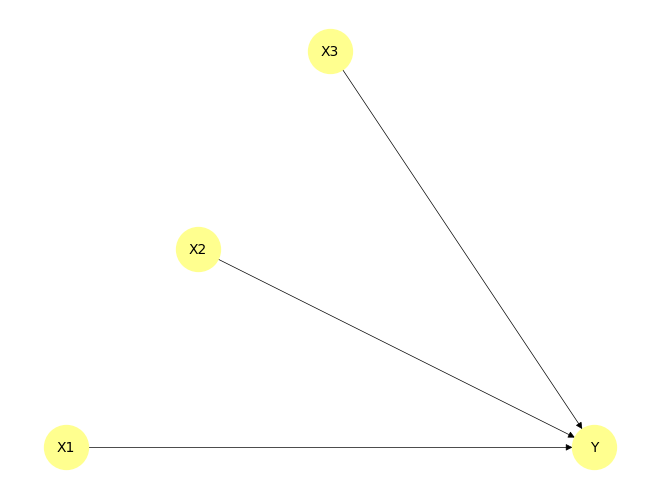

Incorrect DAG 2:


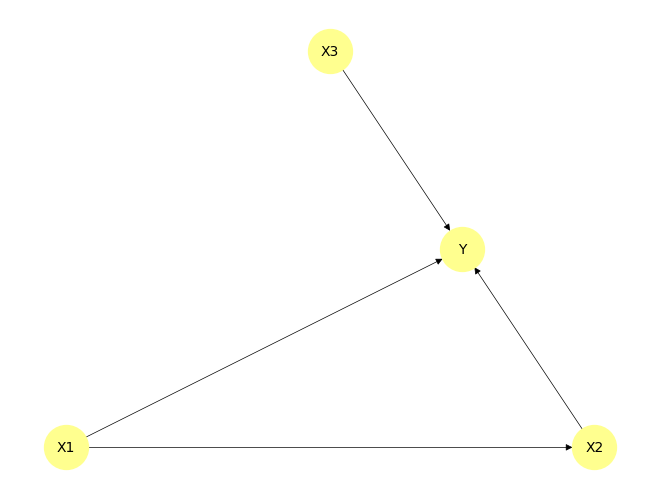

Correct DAG:


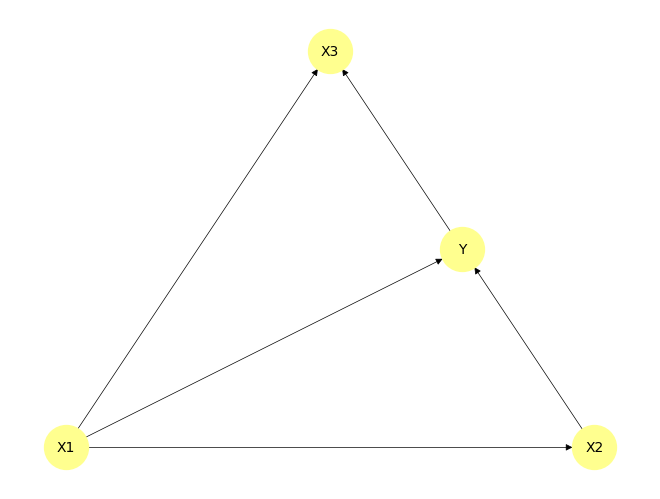

In [5]:
print('Incorrect DAG 1:')
nx.draw_planar(
    DAGnx1,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.5,
    font_size=10,
)
plt.show()

print('Incorrect DAG 2:')
nx.draw_planar(
    DAGnx2,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.5,
    font_size=10,
)
plt.show()

print('Correct DAG:')
nx.draw_planar(
    DAGnx3,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.5,
    font_size=10,
)
plt.show()

We run the model with the same data each time (although the column ordering of the data is different in each case, according to the assumed underlying DAG), and provide fit statistics as well as estimated causal links.

### Incorrect DAG 1 (fully exogenous)

In [6]:
indices = np.arange(0, len(all_data1))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data1[train_inds]
val_data = all_data1[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

input_dim = all_data1.shape[2]

model1 = CaT(input_dim=input_dim,
                dropout_rate=dropout_rate,
                head_size=head_size,
                num_heads=num_heads,
                ff_n_embed=ff_n_embed,
                dag=DAGnx1,
                causal_ordering=causal_ordering1,
                n_layers=n_layers,
                device=device,
                var_types=var_types1,
                ).to(device)

optimizer = torch.optim.AdamW(model1.parameters(), lr=learning_rate)

def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model1.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model1(X=xb, targets=xb_mod, shuffling=shuffling)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model1.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model1(X=xb, targets=xb_mod, shuffling=False)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model1.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")
 

step 0 of 100000: train_loss 2.4101, val loss 2.3839
step 100 of 100000: train_loss 0.7666, val loss 0.7437
step 200 of 100000: train_loss 0.7163, val loss 0.7397
step 300 of 100000: train_loss 0.6994, val loss 0.7230
step 400 of 100000: train_loss 0.6929, val loss 0.7008
step 500 of 100000: train_loss 0.7558, val loss 0.7669
step 600 of 100000: train_loss 0.6983, val loss 0.7122
step 700 of 100000: train_loss 0.6966, val loss 0.6932
step 800 of 100000: train_loss 0.7059, val loss 0.7303
step 900 of 100000: train_loss 0.6915, val loss 0.7133
step 1000 of 100000: train_loss 0.7072, val loss 0.7154
step 1100 of 100000: train_loss 0.7106, val loss 0.7222
step 1200 of 100000: train_loss 0.7069, val loss 0.7036
step 1300 of 100000: train_loss 0.6959, val loss 0.6978
step 1400 of 100000: train_loss 0.7033, val loss 0.6932
step 1500 of 100000: train_loss 0.6986, val loss 0.7096
step 1600 of 100000: train_loss 0.7112, val loss 0.7317
step 1700 of 100000: train_loss 0.6940, val loss 0.6906
step

ATE: [1.36] est ATE: [0.41333425] error: [0.94666575]
Mean Squared Error Across All Vars: tensor(1.8704)
Mean Squared Error Across Outcome: tensor(0.6755)


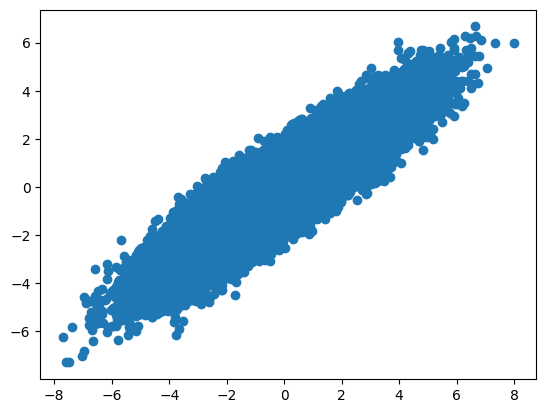

In [5]:
   
model1.eval()
inf = inference.CausalInference(model=model1, device=device)

int_nodes_vals0 = {'X1':np.array([0.0,])}
int_nodes_vals1 = {'X1':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names1.index(effect_var)

preds0 = inf.forward(all_data1, int_nodes_vals0)
preds1 = inf.forward(all_data1, int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model1(train_data.to(device))
plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())
print('Mean Squared Error Across All Vars:', ((train_data - preds.detach().cpu())**2).mean())
print('Mean Squared Error Across Outcome:', ((train_data[:,effect_index,:] - preds[:,effect_index,:].detach().cpu())**2).mean())

## Incorrect DAG 2 (missing and reverse edges)

In [6]:
indices = np.arange(0, len(all_data2))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data2[train_inds]
val_data = all_data2[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

input_dim = all_data2.shape[2]

model2 = CaT(input_dim=input_dim,
                dropout_rate=dropout_rate,
                head_size=head_size,
                num_heads=num_heads,
                ff_n_embed=ff_n_embed,
                dag=DAGnx2,
                causal_ordering=causal_ordering2,
                n_layers=n_layers,
                device=device,
                var_types=var_types2,
                ).to(device)

optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)

def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model2.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model2(X=xb, targets=xb_mod, shuffling=shuffling)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model2.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model2(X=xb, targets=xb_mod, shuffling=False)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model2.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")
 

step 0 of 100000: train_loss 4.8074, val loss 4.7529
step 100 of 100000: train_loss 2.2040, val loss 2.1906
step 200 of 100000: train_loss 1.8700, val loss 1.8562
step 300 of 100000: train_loss 1.7606, val loss 1.7790
step 400 of 100000: train_loss 1.7314, val loss 1.7692
step 500 of 100000: train_loss 1.7488, val loss 1.7697
step 600 of 100000: train_loss 1.7325, val loss 1.7176
step 700 of 100000: train_loss 1.7661, val loss 1.7250
step 800 of 100000: train_loss 1.7229, val loss 1.7408
step 900 of 100000: train_loss 1.7295, val loss 1.7581
step 1000 of 100000: train_loss 1.7567, val loss 1.7457
step 1100 of 100000: train_loss 1.7451, val loss 1.7356
step 1200 of 100000: train_loss 1.7394, val loss 1.7209
step 1300 of 100000: train_loss 1.7344, val loss 1.7203
step 1400 of 100000: train_loss 1.7130, val loss 1.7385
step 1500 of 100000: train_loss 1.7139, val loss 1.7419
step 1600 of 100000: train_loss 1.7192, val loss 1.7246
step 1700 of 100000: train_loss 1.7733, val loss 1.7748
step

ATE: [1.36] est ATE: [0.77096986] error: [0.58903014]
Mean Squared Error Across All Vars: tensor(1.7172)
Mean Squared Error Across Outcome: tensor(0.6801)


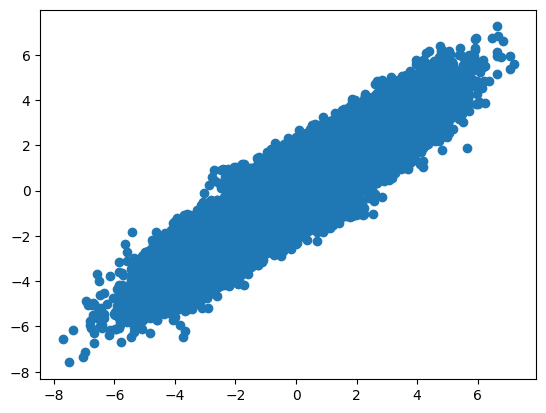

In [7]:
   
model2.eval()
inf = inference.CausalInference(model=model2, device=device)

int_nodes_vals0 = {'X1':np.array([0.0,])}
int_nodes_vals1 = {'X1':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names2.index(effect_var)

preds0 = inf.forward(all_data2, int_nodes_vals0)
preds1 = inf.forward(all_data2, int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model2(train_data.to(device))
plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())
print('Mean Squared Error Across All Vars:', ((train_data - preds.detach().cpu())**2).mean())
print('Mean Squared Error Across Outcome:', ((train_data[:,effect_index,:] - preds[:,effect_index,:].detach().cpu())**2).mean())

## Correct DAG

In [8]:
indices = np.arange(0, len(all_data3))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data3[train_inds]
val_data = all_data3[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

input_dim = all_data3.shape[2]

model3 = CaT(input_dim=input_dim,
                dropout_rate=dropout_rate,
                head_size=head_size,
                num_heads=num_heads,
                ff_n_embed=ff_n_embed,
                dag=DAGnx3,
                causal_ordering=causal_ordering3,
                n_layers=n_layers,
                device=device,
                var_types=var_types3,
                ).to(device)

optimizer = torch.optim.AdamW(model3.parameters(), lr=learning_rate)

def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model3.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model3(X=xb, targets=xb_mod, shuffling=shuffling)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model3.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model3(X=xb, targets=xb_mod, shuffling=False)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model3.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")
 

step 0 of 100000: train_loss 9.0737, val loss 8.5158
step 100 of 100000: train_loss 3.9570, val loss 3.8544
step 200 of 100000: train_loss 3.5596, val loss 3.5411
step 300 of 100000: train_loss 3.4454, val loss 3.4267
step 400 of 100000: train_loss 3.3095, val loss 3.2436
step 500 of 100000: train_loss 3.1468, val loss 3.0873
step 600 of 100000: train_loss 3.1445, val loss 3.1013
step 700 of 100000: train_loss 3.0283, val loss 2.9770
step 800 of 100000: train_loss 3.0610, val loss 3.0133
step 900 of 100000: train_loss 2.9700, val loss 2.9667
step 1000 of 100000: train_loss 2.9918, val loss 2.9122
step 1100 of 100000: train_loss 2.9154, val loss 2.8948
step 1200 of 100000: train_loss 2.8971, val loss 2.8909
step 1300 of 100000: train_loss 2.9564, val loss 2.8773
step 1400 of 100000: train_loss 2.8839, val loss 2.8754
step 1500 of 100000: train_loss 2.9200, val loss 2.9182
step 1600 of 100000: train_loss 2.9383, val loss 2.8307
step 1700 of 100000: train_loss 2.8398, val loss 2.8423
step

ATE: [1.36] est ATE: [1.14525673] error: [0.21474327]
Mean Squared Error Across All Vars: tensor(0.9648)
Mean Squared Error Across Outcome: tensor(0.9709)


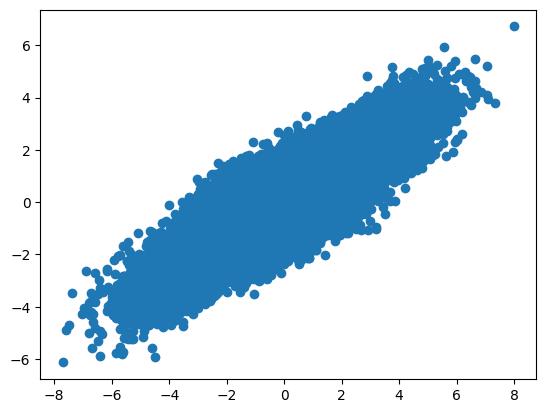

In [9]:
   
model3.eval()
inf = inference.CausalInference(model=model3, device=device)

int_nodes_vals0 = {'X1':np.array([0.0,])}
int_nodes_vals1 = {'X1':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names3.index(effect_var)

preds0 = inf.forward(all_data3, int_nodes_vals0)
preds1 = inf.forward(all_data3, int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model3(train_data.to(device))
plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())
print('Mean Squared Error Across All Vars:', ((train_data - preds.detach().cpu())**2).mean())
print('Mean Squared Error Across Outcome:', ((train_data[:,effect_index,:] - preds[:,effect_index,:].detach().cpu())**2).mean())